
## Intel Berkeley Research Lab Sensor Dataset

This notebook combines the entire data science pipeline:
1. **Data Exploration and Cleaning**
2. **Feature Engineering**
3. **Unsupervised Anomaly Detection**
4. **Supervised Models with Hyperparameter Tuning**

### Dataset Information:
- **Records**: 2,313,682 datapoints
- **Sensors**: 54 Mica2Dot sensors
- **Period**: 36 days (Feb 28 - April 5, 2004)
- **Features**: timestamp, epoch, moteid, temperature, humidity, light, voltage

# Part 1: Data Exploration and Cleaning

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading

In [3]:
# Define column names based on dataset description
column_names = ['timestamp', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']

# Load the dataset
print("Loading dataset... This may take a few minutes.")
df = pd.read_csv(
    'data.txt',
    sep='\s+',
    names=column_names,
    parse_dates=['timestamp'],
    engine='python'
)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading dataset... This may take a few minutes.
Dataset loaded successfully!
Shape: (2313682, 7)
Memory usage: 253.75 MB


In [4]:
# Display first few rows
df.head(10)

,timestamp,epoch,moteid,temperature,humidity,light,voltage
2004-03-31,2025-11-07 03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
2004-02-28,2025-11-07 00:59:16.027850,3,1.0,19.9884,37.09330,45.08,2.69964
2004-02-28,2025-11-07 01:03:16.333930,11,1.0,19.3024,38.46290,45.08,2.68742
2004-02-28,2025-11-07 01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
2004-02-28,2025-11-07 01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964
2004-02-28,2025-11-07 01:08:45.992524,22,1.0,19.1456,38.94010,45.08,2.68742
2004-02-28,2025-11-07 01:09:22.323858,23,1.0,19.1652,38.87200,45.08,2.68742
2004-02-28,2025-11-07 01:09:46.109598,24,1.0,19.1652,38.80390,45.08,2.68742
2004-02-28,2025-11-07 01:10:16.678900,25,1.0,19.1456,38.83790,45.08,2.69964
2004-02-28,2025-11-07 01:10:46.250524,26,1.0,19.1456,38.87200,45.08,2.68742


In [5]:
# Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2313682 entries, 2004-03-31 to 2004-04-02
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   timestamp    datetime64[ns]
 1   epoch        int64         
 2   moteid       float64       
 3   temperature  float64       
 4   humidity     float64       
 5   light        float64       
 6   voltage      float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 141.2+ MB


In [6]:
# Statistical summary
df.describe()

,timestamp,epoch,moteid,temperature,humidity,light,voltage
count,2313682,2.313682e+06,2.313156e+06,2.313156e+06,2.312783e+06,2.312779e+06,2.219803e+06
mean,2025-11-07 11:57:44.601253888,3.303993e+04,2.854412e+01,3.920103e+01,3.390809e+01,3.909430e+02,2.490634e+00
min,2025-11-07 00:00:00.042788,0.000000e+00,1.000000e+00,-3.840000e+01,-8.983130e+03,0.000000e+00,9.100830e-03
25%,2025-11-07 05:51:13.575994624,1.757200e+04,1.700000e+01,2.040980e+01,3.187760e+01,1.840000e+01,2.385220e+00
50%,2025-11-07 12:00:36.797580544,3.332700e+04,2.900000e+01,2.243840e+01,3.928030e+01,1.435200e+02,2.527320e+00
75%,2025-11-07 18:01:11.229721088,4.778900e+04,4.100000e+01,2.701500e+01,4.358550e+01,5.078400e+02,2.627960e+00
max,2025-11-07 23:59:59.959825,6.553500e+04,6.540700e+04,3.855680e+02,1.375120e+02,1.847360e+03,3.159150e+00
std,NaN,1.836852e+04,5.062408e+01,3.741915e+01,1.732155e+01,5.344185e+02,1.784080e-01


## 2. Data Quality Assessment

In [7]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})

print("Missing Values Analysis:")
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values Analysis:
             Missing Count  Percentage
moteid                 526    0.022734
temperature            526    0.022734
humidity               899    0.038856
light                  903    0.039029
voltage              93879    4.057558


In [8]:
# Check for duplicate timestamps per sensor
duplicates = df.duplicated(subset=['timestamp', 'moteid']).sum()
print(f"Duplicate records (same timestamp + moteid): {duplicates}")

# Check unique sensors
unique_sensors = df['moteid'].nunique()
print(f"\nUnique sensors: {unique_sensors}")

Duplicate records (same timestamp + moteid): 1

Unique sensors: 61


In [9]:
# Time range analysis
print("Time Range:")
print(f"Start: {df['timestamp'].min()}")
print(f"End: {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

Time Range:
Start: 2025-11-07 00:00:00.042788
End: 2025-11-07 23:59:59.959825
Duration: 0 days


## 3. Outlier Detection (Initial)

In [10]:
# Check for obvious outliers using IQR method
numeric_cols = ['temperature', 'humidity', 'light', 'voltage']

outlier_info = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_info[col] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(df)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

outlier_df = pd.DataFrame(outlier_info).T
print("Outlier Analysis (3*IQR method):")
print(outlier_df)

Outlier Analysis (3*IQR method):
                count  percentage  lower_bound  upper_bound
temperature  410331.0   17.734978       0.5942     46.83060
humidity     295317.0   12.763941      -3.2461     78.70920
light             0.0    0.000000   -1449.9200   1976.16000
voltage           4.0    0.000173       1.6570      3.35618


## 4. Data Visualization

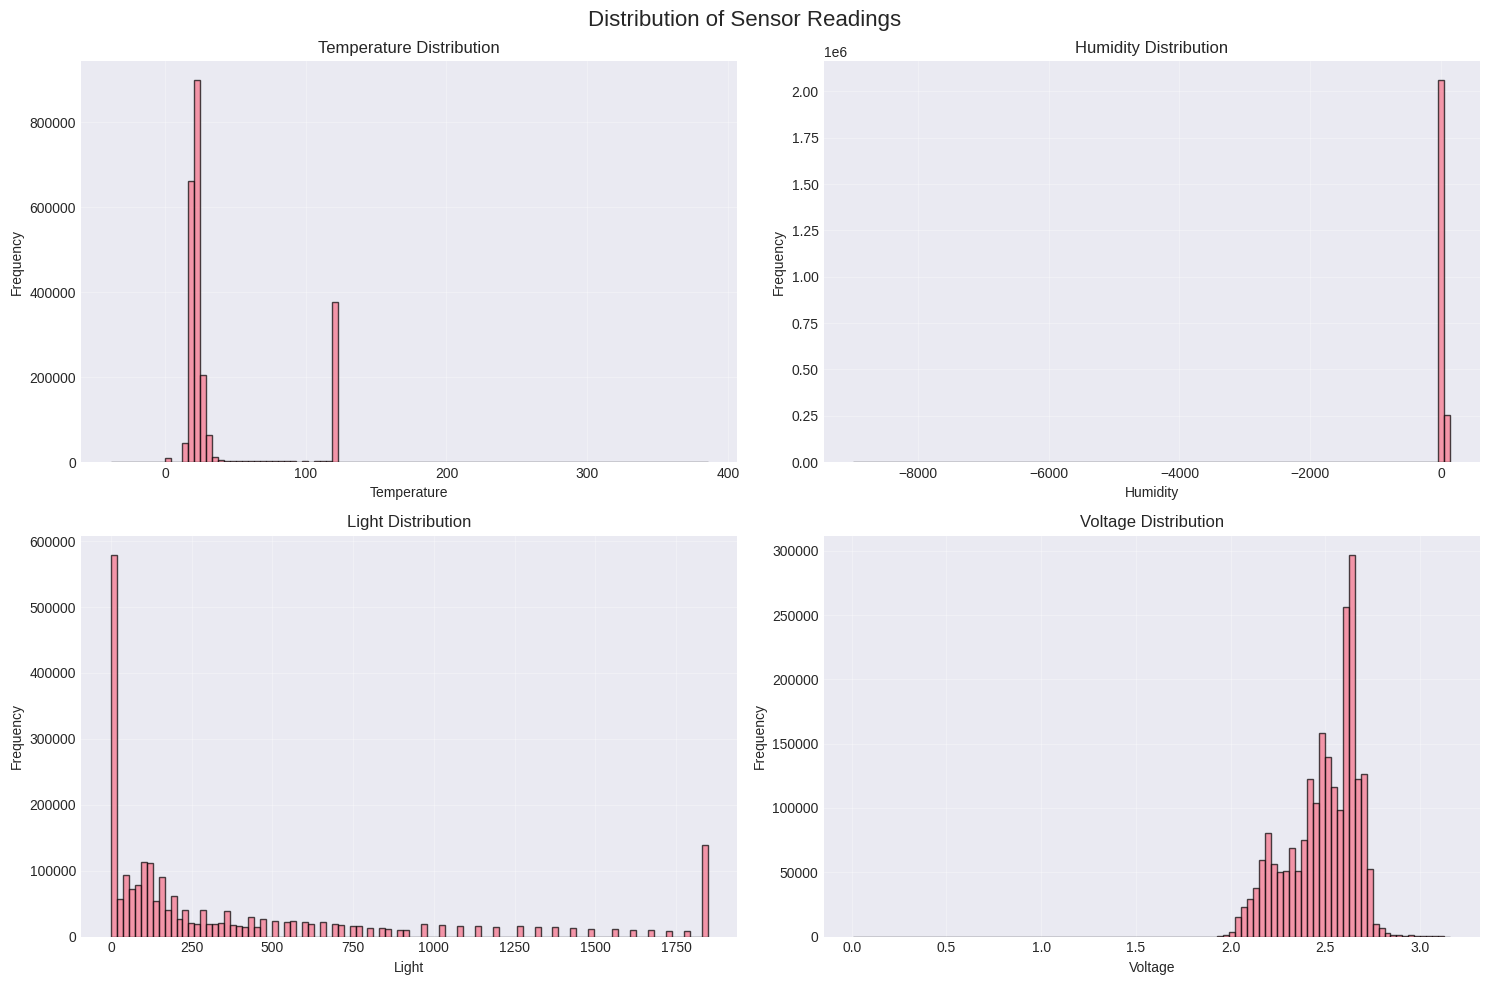

In [11]:
# Distribution plots for all numeric features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Sensor Readings', fontsize=16)

for idx, col in enumerate(numeric_cols):
    ax = axes[idx // 2, idx % 2]
    ax.hist(df[col].dropna(), bins=100, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col.capitalize()} Distribution')
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

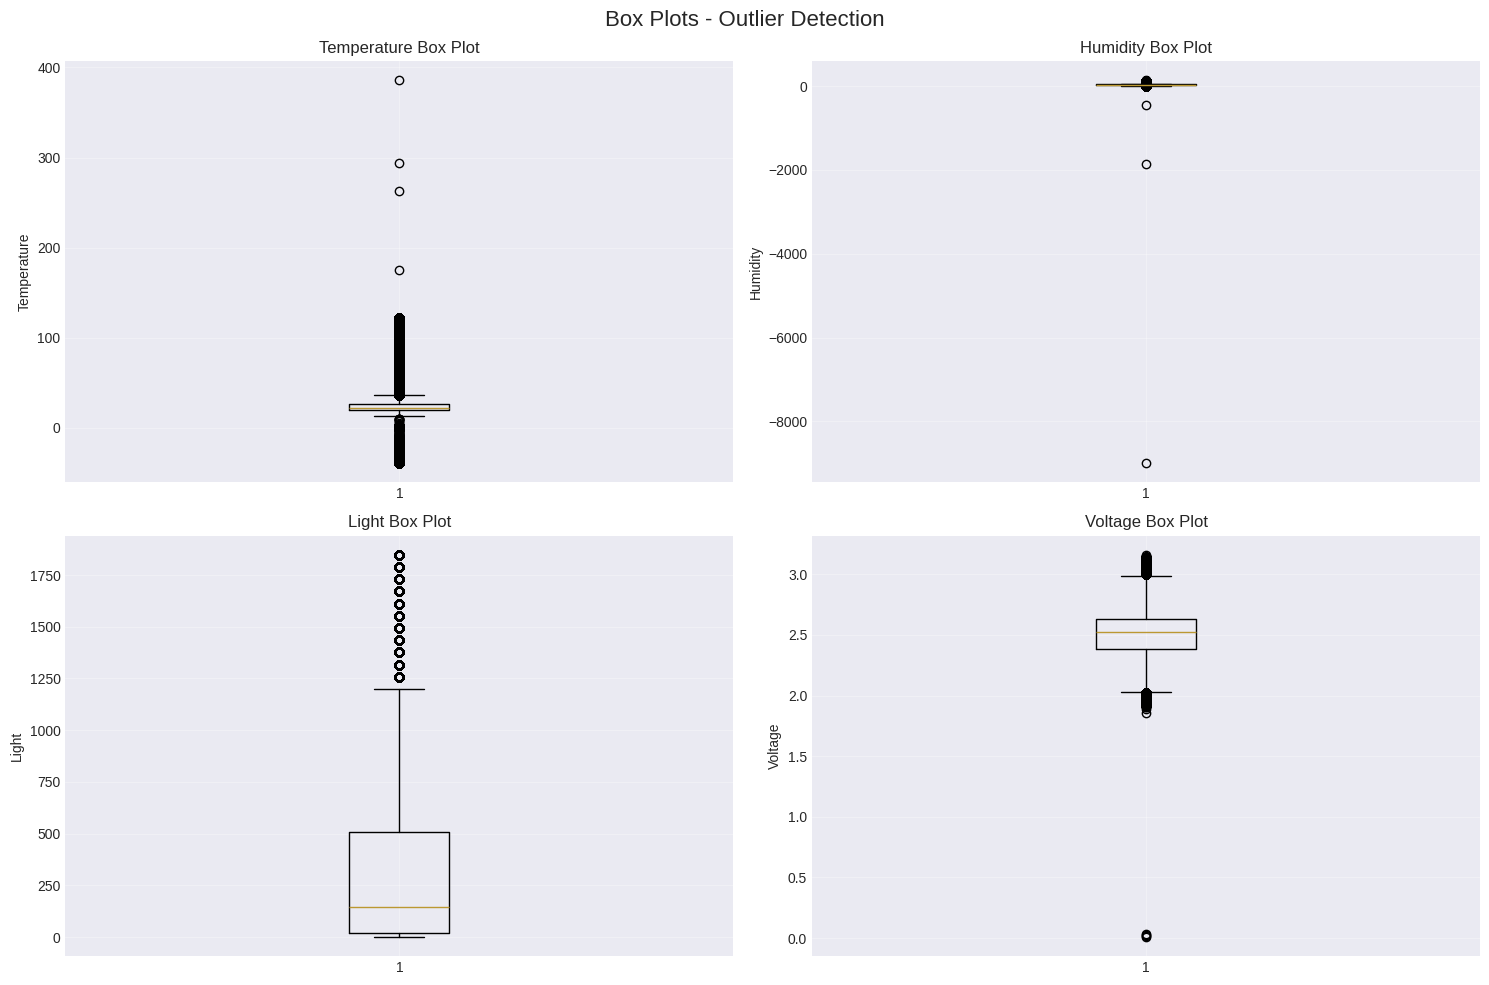

In [12]:
# Box plots for outlier visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Box Plots - Outlier Detection', fontsize=16)

for idx, col in enumerate(numeric_cols):
    ax = axes[idx // 2, idx % 2]
    ax.boxplot(df[col].dropna(), vert=True)
    ax.set_title(f'{col.capitalize()} Box Plot')
    ax.set_ylabel(col.capitalize())
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

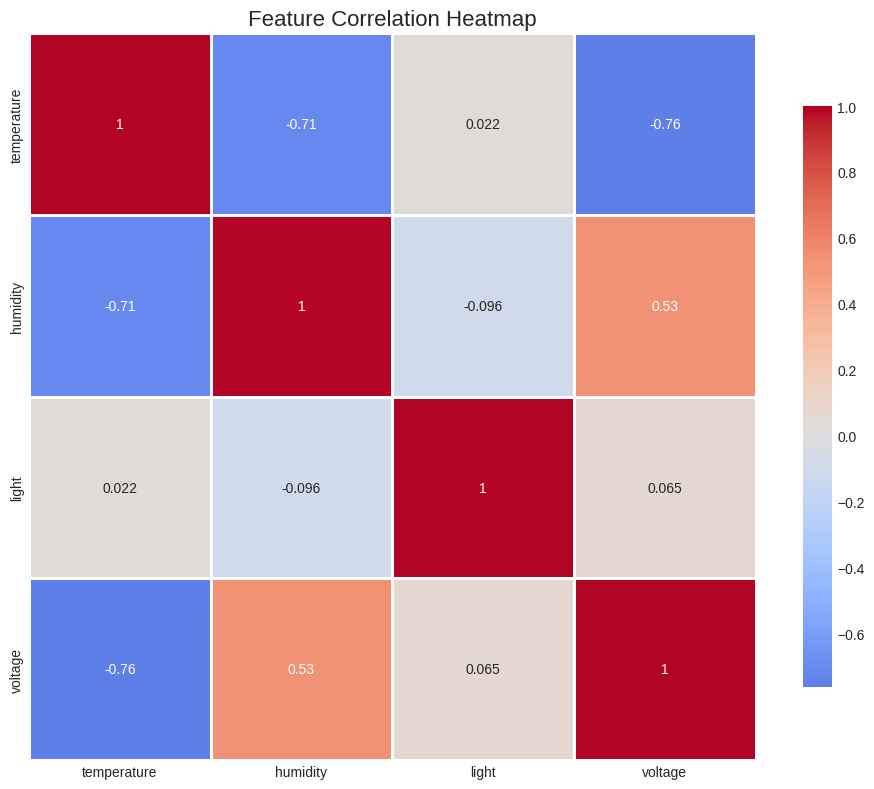

In [13]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Data Cleaning

In [14]:
# Create a copy for cleaning
df_clean = df.copy()

print(f"Original shape: {df_clean.shape}")

# Remove duplicates
df_clean = df_clean.drop_duplicates(subset=['timestamp', 'moteid'], keep='first')
print(f"After removing duplicates: {df_clean.shape}")

# Sort by timestamp and moteid
df_clean = df_clean.sort_values(['moteid', 'timestamp']).reset_index(drop=True)
print(f"Data sorted by moteid and timestamp")

Original shape: (2313682, 7)
After removing duplicates: (2313681, 7)
Data sorted by moteid and timestamp


In [15]:
# Handle missing values - Forward fill then backward fill (within each sensor)
print("Handling missing values...")

# Group by sensor and fill missing values
for col in numeric_cols:
    df_clean[col] = df_clean.groupby('moteid')[col].fillna(method='ffill')
    df_clean[col] = df_clean.groupby('moteid')[col].fillna(method='bfill')

# Check remaining missing values
remaining_missing = df_clean[numeric_cols].isnull().sum()
print(f"\nRemaining missing values after filling:")
print(remaining_missing[remaining_missing > 0])

# Drop rows with any remaining missing values
df_clean = df_clean.dropna()
print(f"\nFinal shape after cleaning: {df_clean.shape}")

Handling missing values...

Remaining missing values after filling:
temperature      526
humidity         561
light            567
voltage        47008
dtype: int64

Final shape after cleaning: (2266673, 7)


In [16]:
# Remove extreme outliers (sensor malfunction)
# Based on domain knowledge: Temperature should be 15-40°C, Humidity 0-100%, Voltage 2-3V

print("Removing extreme outliers...")
original_len = len(df_clean)

df_clean = df_clean[
    (df_clean['temperature'] >= 10) & (df_clean['temperature'] <= 50) &
    (df_clean['humidity'] >= 0) & (df_clean['humidity'] <= 100) &
    (df_clean['voltage'] >= 1.5) & (df_clean['voltage'] <= 3.5) &
    (df_clean['light'] >= 0)
]

removed = original_len - len(df_clean)
print(f"Removed {removed} extreme outlier records ({(removed/original_len)*100:.2f}%)")
print(f"Final cleaned shape: {df_clean.shape}")

Removing extreme outliers...
Removed 409922 extreme outlier records (18.08%)
Final cleaned shape: (1856751, 7)


In [19]:
# Save cleaned data
output_path = 'cleaned_sensor_data.csv'
df_clean.to_csv(output_path, index=False)
print(f"Cleaned data saved to: {output_path}")
print(f"File size: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Cleaned data saved to: cleaned_sensor_data.csv
File size: 217.80 MB


In [20]:
# Summary statistics of cleaned data
print("\n=== CLEANED DATA SUMMARY ===")
print(f"Total records: {len(df_clean):,}")
print(f"Total sensors: {df_clean['moteid'].nunique()}")
print(f"Time period: {df_clean['timestamp'].min()} to {df_clean['timestamp'].max()}")
print(f"Duration: {(df_clean['timestamp'].max() - df_clean['timestamp'].min()).days} days")
print("\nFeature ranges:")
print(df_clean[numeric_cols].describe())


=== CLEANED DATA SUMMARY ===
Total records: 1,856,751
Total sensors: 55
Time period: 2025-11-07 00:00:00.042788 to 2025-11-07 23:59:59.893310
Duration: 0 days

Feature ranges:
        temperature      humidity         light       voltage
count  1.856751e+06  1.856751e+06  1.856751e+06  1.856751e+06
mean   2.226584e+01  3.955558e+01  4.013187e+02  2.555770e+00
std    3.654254e+00  6.269531e+00  5.393060e+02  1.171482e-01
min    1.018840e+01  4.211200e-01  3.077160e-15  1.928310e+00
25%    2.000800e+01  3.554180e+01  3.220000e+01  2.474670e+00
50%    2.180140e+01  4.050040e+01  1.508800e+02  2.582260e+00
75%    2.366340e+01  4.395120e+01  5.372800e+02  2.639640e+00
max    4.999600e+01  6.483000e+01  1.847360e+03  3.159150e+00


# Part 2: Feature Engineering

In [21]:
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

print("Feature engineering libraries loaded!")

Feature engineering libraries loaded!


In [22]:
# Load cleaned data
print("Loading cleaned data...")
df = pd.read_csv('cleaned_sensor_data.csv', parse_dates=['timestamp'])
print(f"Data loaded: {df.shape}")
df.head()

Loading cleaned data...
Data loaded: (1856751, 7)


,timestamp,epoch,moteid,temperature,humidity,light,voltage
0,2025-11-07 00:00:00.042928,8524,1.0,19.3220,40.9055,39.56,2.66332
1,2025-11-07 00:00:03.691696,40204,1.0,20.8704,43.3858,43.24,2.51661
2,2025-11-07 00:00:03.969723,31564,1.0,22.1052,43.5855,39.56,2.59354
3,2025-11-07 00:00:04.761573,17164,1.0,20.4196,37.9161,48.76,2.63964
4,2025-11-07 00:00:05.972850,28684,1.0,22.6834,36.1293,9.20,2.61639


## 1. Temporal Features

In [23]:
print("Creating temporal features...")

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Create cyclical features (sine/cosine encoding for hour and day)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Time since start (in hours)
df['time_since_start'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 3600

print("Temporal features created!")

Creating temporal features...
Temporal features created!


## 2. Rolling Statistics

In [24]:
print("Calculating rolling statistics...")

# Features to calculate rolling stats for
sensor_features = ['temperature', 'humidity', 'light', 'voltage']

# Window sizes (in number of readings)
windows = [10, 30, 60]

# Calculate for each sensor separately
for feature in sensor_features:
    for window in windows:
        # Rolling mean
        df[f'{feature}_rolling_mean_{window}'] = df.groupby('moteid')[feature].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

        # Rolling standard deviation
        df[f'{feature}_rolling_std_{window}'] = df.groupby('moteid')[feature].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

        # Rolling min and max
        df[f'{feature}_rolling_min_{window}'] = df.groupby('moteid')[feature].transform(
            lambda x: x.rolling(window=window, min_periods=1).min()
        )
        df[f'{feature}_rolling_max_{window}'] = df.groupby('moteid')[feature].transform(
            lambda x: x.rolling(window=window, min_periods=1).max()
        )

print(f"Rolling statistics calculated for windows: {windows}")

Calculating rolling statistics...
Rolling statistics calculated for windows: [10, 30, 60]


## 3. Rate of Change Features

In [25]:
print("Calculating rate of change features...")

for feature in sensor_features:
    # First order difference (rate of change)
    df[f'{feature}_diff_1'] = df.groupby('moteid')[feature].diff(1)

    # Second order difference (acceleration)
    df[f'{feature}_diff_2'] = df.groupby('moteid')[feature].diff(2)

    # Percentage change
    df[f'{feature}_pct_change'] = df.groupby('moteid')[feature].pct_change()

    # Deviation from rolling mean
    df[f'{feature}_deviation_from_mean'] = df[feature] - df[f'{feature}_rolling_mean_30']

print("Rate of change features created!")

Calculating rate of change features...
Rate of change features created!


## 4. Lag Features

In [26]:
print("Creating lag features...")

# Create lag features (previous values)
lag_periods = [1, 2, 5, 10]

for feature in sensor_features:
    for lag in lag_periods:
        df[f'{feature}_lag_{lag}'] = df.groupby('moteid')[feature].shift(lag)

print(f"Lag features created for periods: {lag_periods}")

Creating lag features...
Lag features created for periods: [1, 2, 5, 10]


## 5. Statistical Features

In [27]:
print("Creating statistical features...")

# Z-score (standardized values within each sensor)
for feature in sensor_features:
    df[f'{feature}_zscore'] = df.groupby('moteid')[feature].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Exponential Moving Average
for feature in sensor_features:
    df[f'{feature}_ema'] = df.groupby('moteid')[feature].transform(
        lambda x: x.ewm(span=30, adjust=False).mean()
    )

print("Statistical features created!")

Creating statistical features...
Statistical features created!


## 6. Inter-Sensor Features

In [28]:
print("Creating inter-sensor features...")

# Calculate global statistics (across all sensors) for each timestamp
for feature in sensor_features:
    # Global mean at each timestamp
    global_stats = df.groupby('timestamp')[feature].agg(['mean', 'std', 'min', 'max'])
    global_stats.columns = [f'{feature}_global_mean', f'{feature}_global_std',
                           f'{feature}_global_min', f'{feature}_global_max']

    df = df.merge(global_stats, on='timestamp', how='left')

    # Deviation from global mean
    df[f'{feature}_deviation_from_global'] = df[feature] - df[f'{feature}_global_mean']

    # Normalized deviation (z-score relative to global)
    df[f'{feature}_global_zscore'] = df[f'{feature}_deviation_from_global'] / (df[f'{feature}_global_std'] + 1e-6)

print("Inter-sensor features created!")

Creating inter-sensor features...
Inter-sensor features created!


## 7. Interaction Features

In [29]:
print("Creating interaction features...")

# Temperature-Humidity interaction
df['temp_humidity_ratio'] = df['temperature'] / (df['humidity'] + 1)

# Light-Temperature interaction (could indicate time of day effects)
df['light_temp_interaction'] = df['light'] * df['temperature']

# Voltage drop (battery health indicator)
df['voltage_drop_rate'] = df.groupby('moteid')['voltage'].transform(
    lambda x: x.diff().rolling(window=50, min_periods=1).mean()
)

print("Interaction features created!")

Creating interaction features...
Interaction features created!


## 8. Handle NaN Values from Feature Engineering

In [30]:
print("Handling NaN values from feature engineering...")
print(f"Shape before: {df.shape}")

# Fill NaN values created by lag and rolling operations
df = df.groupby('moteid').fillna(method='ffill').fillna(method='bfill')

# Drop any remaining NaN
df = df.dropna()

print(f"Shape after: {df.shape}")
print(f"Remaining NaN values: {df.isnull().sum().sum()}")

Handling NaN values from feature engineering...
Shape before: (1856751, 132)
Shape after: (1846891, 131)
Remaining NaN values: 0


## 9. Feature Summary

In [31]:
print("\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"Total features: {len(df.columns)}")
print(f"Total records: {len(df):,}")
print(f"\nFeature categories:")

original_features = ['timestamp', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']
temporal_features = [col for col in df.columns if any(x in col for x in ['hour', 'day', 'week', 'weekend', 'sin', 'cos', 'time_since'])]
rolling_features = [col for col in df.columns if 'rolling' in col]
diff_features = [col for col in df.columns if 'diff' in col or 'pct_change' in col]
lag_features = [col for col in df.columns if 'lag' in col]
statistical_features = [col for col in df.columns if any(x in col for x in ['zscore', 'ema', 'deviation'])]
global_features = [col for col in df.columns if 'global' in col]
interaction_features = [col for col in df.columns if any(x in col for x in ['ratio', 'interaction', 'drop_rate'])]

print(f"  - Original features: {len(original_features)}")
print(f"  - Temporal features: {len(temporal_features)}")
print(f"  - Rolling statistics: {len(rolling_features)}")
print(f"  - Rate of change features: {len(diff_features)}")
print(f"  - Lag features: {len(lag_features)}")
print(f"  - Statistical features: {len(statistical_features)}")
print(f"  - Global/Inter-sensor features: {len(global_features)}")
print(f"  - Interaction features: {len(interaction_features)}")


=== FEATURE ENGINEERING SUMMARY ===
Total features: 131
Total records: 1,846,891

Feature categories:
  - Original features: 7
  - Temporal features: 10
  - Rolling statistics: 48
  - Rate of change features: 12
  - Lag features: 16
  - Statistical features: 20
  - Global/Inter-sensor features: 24
  - Interaction features: 3


In [33]:
# Save the complete feature-engineered dataset
output_path = 'featured_sensor_data.csv'
df.to_csv(output_path, index=False)

print(f"\nFeature-engineered data saved to: {output_path}")
print(f"Final shape: {df.shape}")
print(f"File size: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Save feature names for later use
feature_cols = [col for col in df.columns if col not in ['timestamp', 'epoch']]
pd.Series(feature_cols).to_csv('feature_names.csv', index=False, header=False)
print(f"\nFeature names saved for model training")


Feature-engineered data saved to: featured_sensor_data.csv
Final shape: (1846891, 131)
File size: 1963.89 MB

Feature names saved for model training


# Part 3: Unsupervised Anomaly Detection

In [34]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Unsupervised learning libraries loaded!")
print(f"TensorFlow version: {tf.__version__}")

Unsupervised learning libraries loaded!
TensorFlow version: 2.19.0


In [35]:
print("Loading feature-engineered data...")
df = pd.read_csv('featured_sensor_data.csv', parse_dates=['timestamp'])
print(f"Data shape: {df.shape}")
df.head()

Loading feature-engineered data...
Data shape: (1846891, 131)


,timestamp,epoch,temperature,humidity,light,voltage,hour,day_of_week,day_of_month,week_of_year,is_weekend,hour_sin,hour_cos,day_sin,day_cos,time_since_start,temperature_rolling_mean_10,temperature_rolling_std_10,temperature_rolling_min_10,temperature_rolling_max_10,temperature_rolling_mean_30,temperature_rolling_std_30,temperature_rolling_min_30,temperature_rolling_max_30,temperature_rolling_mean_60,temperature_rolling_std_60,temperature_rolling_min_60,temperature_rolling_max_60,humidity_rolling_mean_10,humidity_rolling_std_10,humidity_rolling_min_10,humidity_rolling_max_10,humidity_rolling_mean_30,humidity_rolling_std_30,humidity_rolling_min_30,humidity_rolling_max_30,humidity_rolling_mean_60,humidity_rolling_std_60,humidity_rolling_min_60,humidity_rolling_max_60,light_rolling_mean_10,light_rolling_std_10,light_rolling_min_10,light_rolling_max_10,light_rolling_mean_30,light_rolling_std_30,light_rolling_min_30,light_rolling_max_30,light_rolling_mean_60,light_rolling_std_60,light_rolling_min_60,light_rolling_max_60,voltage_rolling_mean_10,voltage_rolling_std_10,voltage_rolling_min_10,voltage_rolling_max_10,voltage_rolling_mean_30,voltage_rolling_std_30,voltage_rolling_min_30,voltage_rolling_max_30,voltage_rolling_mean_60,voltage_rolling_std_60,voltage_rolling_min_60,voltage_rolling_max_60,temperature_diff_1,temperature_diff_2,temperature_pct_change,temperature_deviation_from_mean,humidity_diff_1,humidity_diff_2,humidity_pct_change,humidity_deviation_from_mean,light_diff_1,light_diff_2,light_pct_change,light_deviation_from_mean,voltage_diff_1,voltage_diff_2,voltage_pct_change,voltage_deviation_from_mean,temperature_lag_1,temperature_lag_2,temperature_lag_5,temperature_lag_10,humidity_lag_1,humidity_lag_2,humidity_lag_5,humidity_lag_10,light_lag_1,light_lag_2,light_lag_5,light_lag_10,voltage_lag_1,voltage_lag_2,voltage_lag_5,voltage_lag_10,temperature_zscore,humidity_zscore,light_zscore,voltage_zscore,temperature_ema,humidity_ema,light_ema,voltage_ema,temperature_global_mean,temperature_global_std,temperature_global_min,temperature_global_max,temperature_deviation_from_global,temperature_global_zscore,humidity_global_mean,humidity_global_std,humidity_global_min,humidity_global_max,humidity_deviation_from_global,humidity_global_zscore,light_global_mean,light_global_std,light_global_min,light_global_max,light_deviation_from_global,light_global_zscore,voltage_global_mean,voltage_global_std,voltage_global_min,voltage_global_max,voltage_deviation_from_global,voltage_global_zscore,temp_humidity_ratio,light_temp_interaction,voltage_drop_rate
0,2025-11-07 00:00:00.042928,8524,19.3220,40.9055,39.56,2.66332,0,4,7,45,0,0.0,1.0,-0.433884,-0.900969,3.888889e-08,19.322000,1.094884,19.322,19.3220,19.322000,1.094884,19.322,19.3220,19.322000,1.094884,19.322,19.3220,40.905500,1.753837,40.9055,40.9055,40.905500,1.753837,40.9055,40.9055,40.905500,1.753837,40.9055,40.9055,39.560000,2.602153,39.56,39.56,39.560000,2.602153,39.56,39.56,39.560000,2.602153,39.56,39.56,2.663320,0.103740,2.66332,2.66332,2.663320,0.103740,2.66332,2.66332,2.663320,0.103740,2.66332,2.66332,1.5484,2.7832,0.080137,0.000000,2.4803,2.6800,0.060635,0.000000,3.68,0.00,0.093023,0.000000,-0.14671,-0.06978,-0.055085,0.000000,19.3220,19.3220,19.322,19.322,40.9055,40.9055,40.9055,40.9055,39.56,39.56,39.56,39.56,2.66332,2.66332,2.66332,2.66332,-0.973422,0.477157,-0.660069,0.810354,19.322000,40.905500,39.560000,2.663320,19.3220,1.670045,19.3220,19.3220,0.0,0.707106,40.9055,0.242679,40.9055,40.9055,0.0,-0.707104,39.56,31.225835,39.56,39.56,0.0,0.707107,2.66332,0.025682,2.66332,2.66332,0.0,0.707079,0.461085,764.378320,-0.146710
1,2025-11-07 00:00:03.691696,40204,20.8704,43.3858,43.24,2.51661,0,4,7,45,0,0.0,1.0,-0.433884,-0.900969,1.013586e-03,20.096200,1.094884,19.322,20.8704,20.096200,1.094884,19.322,20.8704,20.096200,1.094884,19.322,20.8704,42.145650,1.753837,40.9055,43.3858,42.145650,1.753837,40.9055,43.3858,42.145650,1.753837,40.9055,43.3858,41.400000,2.602153,39.56,43.24,41.400000,2.602

In [36]:
# Prepare feature matrix
exclude_cols = ['timestamp', 'epoch']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].values
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")

Feature matrix shape: (1846891, 129)
Number of features: 129


## 1. Data Preprocessing & Scaling

In [38]:
# Use RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("Data scaled using RobustScaler")
print(f"Scaled data shape: {X_scaled.shape}")

# Save scaler for later use
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved!")

Data scaled using RobustScaler
Scaled data shape: (1846891, 129)
Scaler saved!


In [39]:
# Use full dataset for training
USE_SAMPLE = False
SAMPLE_SIZE = 200000

if USE_SAMPLE and len(X_scaled) > SAMPLE_SIZE:
    sample_indices = np.random.choice(len(X_scaled), SAMPLE_SIZE, replace=False)
    X_train = X_scaled[sample_indices]
    df_train = df.iloc[sample_indices].copy()
    print(f"Using sample of {SAMPLE_SIZE:,} records for training")
else:
    X_train = X_scaled
    df_train = df.copy()
    print(f"Using FULL DATASET: {len(X_train):,} records")

print(f"Training data shape: {X_train.shape}")

Using FULL DATASET: 1,846,891 records
Training data shape: (1846891, 129)


## 2. Model 1: Isolation Forest

In [40]:
print("="*50)
print("ISOLATION FOREST")
print("="*50)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_samples': [256, 512],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [0.5, 1.0]
}

print("\nTesting hyperparameter combinations...")
best_score = -np.inf
best_params = None

for n_est in param_grid['n_estimators']:
    for max_samp in param_grid['max_samples']:
        for cont in param_grid['contamination']:
            for max_feat in param_grid['max_features']:
                iso_forest = IsolationForest(
                    n_estimators=n_est,
                    max_samples=max_samp,
                    contamination=cont,
                    max_features=max_feat,
                    random_state=42,
                    n_jobs=-1
                )
                iso_forest.fit(X_train)
                score = iso_forest.score_samples(X_train).mean()

                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_est,
                        'max_samples': max_samp,
                        'contamination': cont,
                        'max_features': max_feat
                    }

print(f"\nBest parameters: {best_params}")
print(f"Best score: {best_score:.4f}")

ISOLATION FOREST

Testing hyperparameter combinations...

Best parameters: {'n_estimators': 100, 'max_samples': 512, 'contamination': 0.01, 'max_features': 1.0}
Best score: -0.4289


In [42]:
# Train final Isolation Forest model
iso_forest_final = IsolationForest(**best_params, random_state=42, n_jobs=-1)
iso_forest_final.fit(X_train)

# Predict on full scaled data
iso_predictions = iso_forest_final.predict(X_scaled)
iso_scores = iso_forest_final.score_samples(X_scaled)

# Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
iso_anomalies = (iso_predictions == -1).astype(int)

print(f"\nIsolation Forest Results:")
print(f"Total anomalies detected: {iso_anomalies.sum():,} ({(iso_anomalies.sum()/len(iso_anomalies))*100:.2f}%)")
print(f"Normal instances: {(iso_anomalies == 0).sum():,} ({((iso_anomalies == 0).sum()/len(iso_anomalies))*100:.2f}%)")

# Save model
joblib.dump(iso_forest_final, 'isolation_forest.pkl')
print("\nModel saved!")


Isolation Forest Results:
Total anomalies detected: 18,469 (1.00%)
Normal instances: 1,828,422 (99.00%)

Model saved!


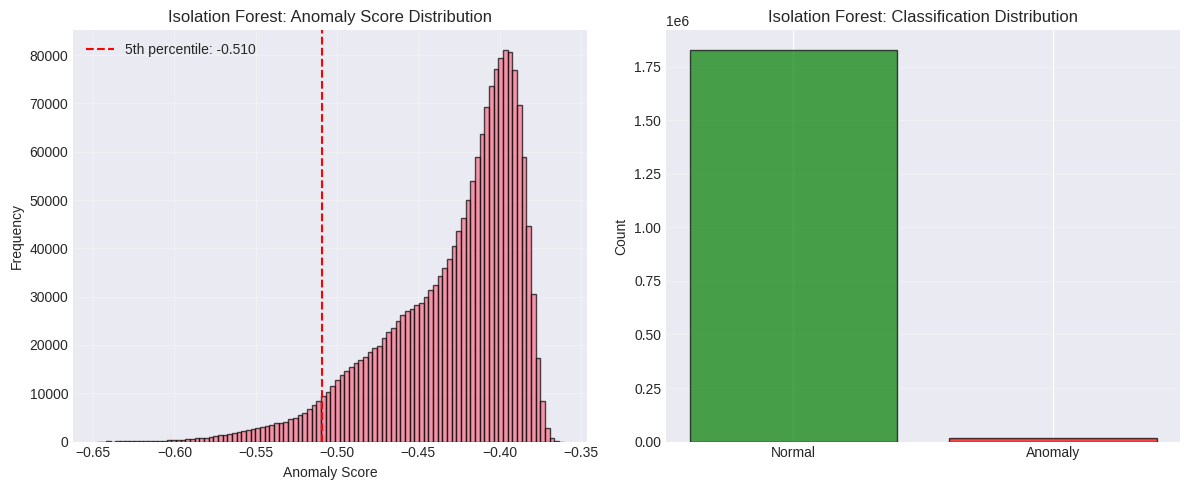

In [43]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(iso_scores, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(x=np.percentile(iso_scores, 5), color='red', linestyle='--',
            label=f'5th percentile: {np.percentile(iso_scores, 5):.3f}')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest: Anomaly Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
labels, counts = np.unique(iso_anomalies, return_counts=True)
plt.bar(['Normal', 'Anomaly'], counts, color=['green', 'red'], alpha=0.7, edgecolor='black')
plt.ylabel('Count')
plt.title('Isolation Forest: Classification Distribution')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Model 2: Autoencoder

In [44]:
print("="*50)
print("AUTOENCODER")
print("="*50)

# Prepare data
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

# Split into train and validation
split_idx = int(0.8 * len(X_train))
X_ae_train = X_train[:split_idx]
X_ae_val = X_train[split_idx:]

print(f"Training samples: {len(X_ae_train):,}")
print(f"Validation samples: {len(X_ae_val):,}")

AUTOENCODER
Input dimension: 129
Training samples: 1,477,512
Validation samples: 369,379


In [45]:
# Build Autoencoder architecture
def build_autoencoder(input_dim, encoding_dims=[128, 64, 32]):
    # Encoder
    encoder_input = keras.Input(shape=(input_dim,))
    x = encoder_input

    for dim in encoding_dims:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

    # Bottleneck
    encoded = layers.Dense(encoding_dims[-1] // 2, activation='relu', name='bottleneck')(x)

    # Decoder
    x = encoded
    for dim in reversed(encoding_dims):
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

    decoder_output = layers.Dense(input_dim, activation='linear')(x)

    # Create model
    autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')

    return autoencoder

# Build model
autoencoder = build_autoencoder(input_dim)
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 129)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 129)            │        16,641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,913 (222.32 KB)

 Trainable params: 56,017 (218.82 KB)

 Non-trainable params: 896 (3.50 KB)

In [46]:
# Compile model
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# Train model
print("\nTraining Autoencoder...")
history = autoencoder.fit(
    X_ae_train, X_ae_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_ae_val, X_ae_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")


Training Autoencoder...
Epoch 1/50
5772/5772 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 401546255616538836992.0000 - mae: 891283.2500 - val_loss: 566.9784 - val_mae: 0.8318 - learning_rate: 0.0010
Epoch 2/50
5772/5772 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 401546255616538836992.0000 - mae: 891283.1875 - val_loss: 572.0816 - val_mae: 0.8386 - learning_rate: 0.0010
Epoch 3/50
5772/5772 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 401546255616538836992.0000 - mae: 891283.3125 - val_loss: 569.3259 - val_mae: 0.8634 - learning_rate: 0.0010
Epoch 4/50
5772/5772 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 401546255616538836992.0000 - mae: 891283.3125 - val_loss: 522.9514 - val_mae: 0.8441 - learning_rate: 0.0010
Epoch 5/50
5772/5772 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 401546255616538836992.0000 - mae: 891283.3125 - val_loss: 404.6370 - val_mae: 0.7903 - learning_rate: 0.0010
Epoch 6/50
5772/5772 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 401546255616538836992.0000 - mae: 891283.3750 - val_

In [47]:
# Calculate reconstruction errors
reconstructions = autoencoder.predict(X_scaled, batch_size=1024)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

print("Reconstruction error statistics:")
print(f"Mean: {mse.mean():.6f}")
print(f"Std: {mse.std():.6f}")
print(f"Min: {mse.min():.6f}")
print(f"Max: {mse.max():.6f}")

# Set threshold (95th percentile)
threshold_percentile = 95
threshold = np.percentile(mse, threshold_percentile)
print(f"\nAnomaly threshold ({threshold_percentile}th percentile): {threshold:.6f}")

# Classify anomalies
ae_anomalies = (mse > threshold).astype(int)

print(f"\nAutoencoder Results:")
print(f"Anomalies detected: {ae_anomalies.sum():,} ({(ae_anomalies.sum()/len(ae_anomalies))*100:.2f}%)")
print(f"Normal instances: {(ae_anomalies == 0).sum():,}")

# Save model and threshold
autoencoder.save('../models/saved_models/autoencoder.h5')
np.save('../models/saved_models/ae_threshold.npy', threshold)
print("\nModel and threshold saved!")

1804/1804 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


Reconstruction error statistics:
Mean: 700624611803519385600.000000
Std: 952151167387201158774784.000000
Min: 0.082016
Max: 1293977289918413624051761152.000000

Anomaly threshold (95th percentile): 56.393212

Autoencoder Results:
Anomalies detected: 92,345 (5.00%)
Normal instances: 1,754,546

Model and threshold saved!


## 4. Ensemble Results

In [49]:
# Add predictions to dataframe
df['iso_forest_anomaly'] = iso_anomalies
df['ae_anomaly'] = ae_anomalies

# Ensemble: if both models agree, it's an anomaly
df['ensemble_anomaly'] = ((df['iso_forest_anomaly'] + df['ae_anomaly']) >= 1).astype(int)

print("Model predictions comparison:")
print(f"Isolation Forest: {iso_anomalies.sum():,} anomalies")
print(f"Autoencoder: {ae_anomalies.sum():,} anomalies")
print(f"\nEnsemble: {df['ensemble_anomaly'].sum():,} anomalies ({(df['ensemble_anomaly'].sum()/len(df))*100:.2f}%)")

Model predictions comparison:
Isolation Forest: 18,469 anomalies
Autoencoder: 92,345 anomalies

Ensemble: 110,342 anomalies (5.97%)


In [50]:
# Save predictions
output_path = 'unsupervised_predictions.csv'
df.to_csv(output_path, index=False)
print(f"Predictions saved to: {output_path}")

Predictions saved to: unsupervised_predictions.csv


# Part 4: Supervised Models with Hyperparameter Tuning

In [54]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from bayes_opt import BayesianOptimization

print("Supervised learning libraries imported!")

Supervised learning libraries imported!


In [53]:
!pip install bayesian-optimization

In [55]:
print("Loading data with pseudo-labels...")
df = pd.read_csv('unsupervised_predictions.csv', parse_dates=['timestamp'])
print(f"Data shape: {df.shape}")

# Use ensemble labels as target
target_col = 'ensemble_anomaly'

print(f"\nTarget variable: {target_col}")
print(f"Class distribution:")
print(df[target_col].value_counts())
print(f"\nAnomaly percentage: {(df[target_col].sum()/len(df))*100:.2f}%")

Loading data with pseudo-labels...
Data shape: (1846891, 134)

Target variable: ensemble_anomaly
Class distribution:
ensemble_anomaly
0    1736549
1     110342
Name: count, dtype: int64

Anomaly percentage: 5.97%


In [56]:
# Prepare features and target
exclude_cols = ['timestamp', 'epoch', 'iso_forest_anomaly', 'ae_anomaly', 'ensemble_anomaly']

feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols].values
y = df[target_col].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_cols)}")


Feature matrix shape: (1846891, 129)
Target shape: (1846891,)
Number of features: 129


## 1. Train-Test Split

In [57]:
# Time-series split (important for temporal data)
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Temporal train-test split:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining class distribution:")
print(f"  Normal: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"  Anomaly: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")

Temporal train-test split:
Training set: (1477512, 129)
Test set: (369379, 129)

Training class distribution:
  Normal: 1,387,734 (93.92%)
  Anomaly: 89,778 (6.08%)


## 2. Handle Class Imbalance with SMOTE

In [58]:
# Apply SMOTE for balanced training
print("Applying SMOTE for class balance...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nBalanced training set: {X_train_balanced.shape}")
print(f"Balanced class distribution:")
print(f"  Normal: {(y_train_balanced == 0).sum():,}")
print(f"  Anomaly: {(y_train_balanced == 1).sum():,}")

Applying SMOTE for class balance...

Balanced training set: (2775468, 129)
Balanced class distribution:
  Normal: 1,387,734
  Anomaly: 1,387,734


## 3. Model 1: Random Forest with GridSearchCV

In [60]:
from sklearn.ensemble import RandomForestClassifier



print("="*50)
print("STANDARD RANDOM FOREST CLASSIFIER")
print("="*50)

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

print(f"\nStarting Random Forest training with default parameters...")
print(f"n_estimators default: {rf.get_params()['n_estimators']}")
print(f"max_depth default: {rf.get_params()['max_depth']}")
print("-" * 50)

rf.fit(X_train_balanced, y_train_balanced)

print("\nRandom Forest model training completed successfully!")
print("The fitted model object is available in the variable 'rf'.")


STANDARD RANDOM FOREST CLASSIFIER

Starting Random Forest training with default parameters...
n_estimators default: 100
max_depth default: None
--------------------------------------------------

Random Forest model training completed successfully!
The fitted model object is available in the variable 'rf'.


In [61]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

rf_standard = rf

y_pred_rf = rf_standard.predict(X_test)
y_pred_proba_rf = rf_standard.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("STANDARD RANDOM FOREST EVALUATION")
print("="*50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Anomaly']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

joblib.dump(rf_standard, 'random_forest_standard.pkl')
print("\nModel saved as 'random_forest_standard.pkl'!")


STANDARD RANDOM FOREST EVALUATION

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    348815
     Anomaly       0.99      0.97      0.98     20564

    accuracy                           1.00    369379
   macro avg       0.99      0.99      0.99    369379
weighted avg       1.00      1.00      1.00    369379


Accuracy: 0.9981
Precision: 0.9912
Recall: 0.9749
F1 Score: 0.9829
ROC-AUC: 0.9998

Model saved as 'random_forest_standard.pkl'!


## 4. Model 2: XGBoost with Bayesian Optimization

In [64]:
import numpy as np
import pandas as pd
import xgboost as xgb

print("="*50)
print("STANDARD XGBOOST CLASSIFIER TRAINING")
print("="*50)

# Calculate scale_pos_weight for imbalanced data
count_normal = (y_train_balanced == 0).sum()
count_anomaly = (y_train_balanced == 1).sum()
# Ensure no division by zero if somehow no anomalies are present after balancing
scale_pos_weight = count_normal / (count_anomaly if count_anomaly > 0 else 1)
print(f"\nScale pos weight (0/1): {scale_pos_weight:.2f}")

# Define Standard XGBoost parameters
# These are sensible defaults, sometimes inspired by the optimization bounds
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss', # A common evaluation metric
    'max_depth': 4,           # A common value for starting out
    'learning_rate': 0.1,     # Faster than the bounds, good for standard training
    'n_estimators': 200,      # A moderate number of trees
    'scale_pos_weight': scale_pos_weight, # Crucial for your imbalanced data
    'random_state': 42,
    'tree_method': 'hist',
    'n_jobs': -1
}

print("\nStarting standard XGBoost training...")
print(f"Using n_estimators: {xgb_params['n_estimators']}")
print(f"Using scale_pos_weight: {xgb_params['scale_pos_weight']:.2f}")
print("-" * 50)

# Initialize and Train Model
xgb_model = xgb.XGBClassifier(**xgb_params)

# Fit on the full training data
xgb_model.fit(X_train_balanced, y_train_balanced)

print("\nXGBoost training completed successfully!")
print("The fitted model object is available in the variable 'xgb_model'.")

STANDARD XGBOOST CLASSIFIER TRAINING

Scale pos weight (0/1): 1.00

Starting standard XGBoost training...
Using n_estimators: 200
Using scale_pos_weight: 1.00
--------------------------------------------------

XGBoost training completed successfully!
The fitted model object is available in the variable 'xgb_model'.


In [65]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("STANDARD XGBOOST EVALUATION")
print("="*50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Anomaly']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

xgb_model.save_model('xgboost_standard_model.json')
print("\nModel saved as 'xgboost_standard_model.json'!")


STANDARD XGBOOST EVALUATION

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    348815
     Anomaly       0.98      0.99      0.98     20564

    accuracy                           1.00    369379
   macro avg       0.99      0.99      0.99    369379
weighted avg       1.00      1.00      1.00    369379


Accuracy: 0.9981
Precision: 0.9796
Recall: 0.9859
F1 Score: 0.9827
ROC-AUC: 0.9996

Model saved as 'xgboost_standard_model.json'!


## 5. Final Model Comparison

In [66]:
# Compare all models
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(models_comparison.to_string(index=False))

# Save comparison
models_comparison.to_csv('../models/saved_models/supervised_models_comparison.csv', index=False)
print("\nComparison saved!")


MODEL COMPARISON
        Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Random Forest  0.998116   0.991150 0.974859  0.982937 0.999773
      XGBoost  0.998070   0.979562 0.985898  0.982720 0.999638

Comparison saved!


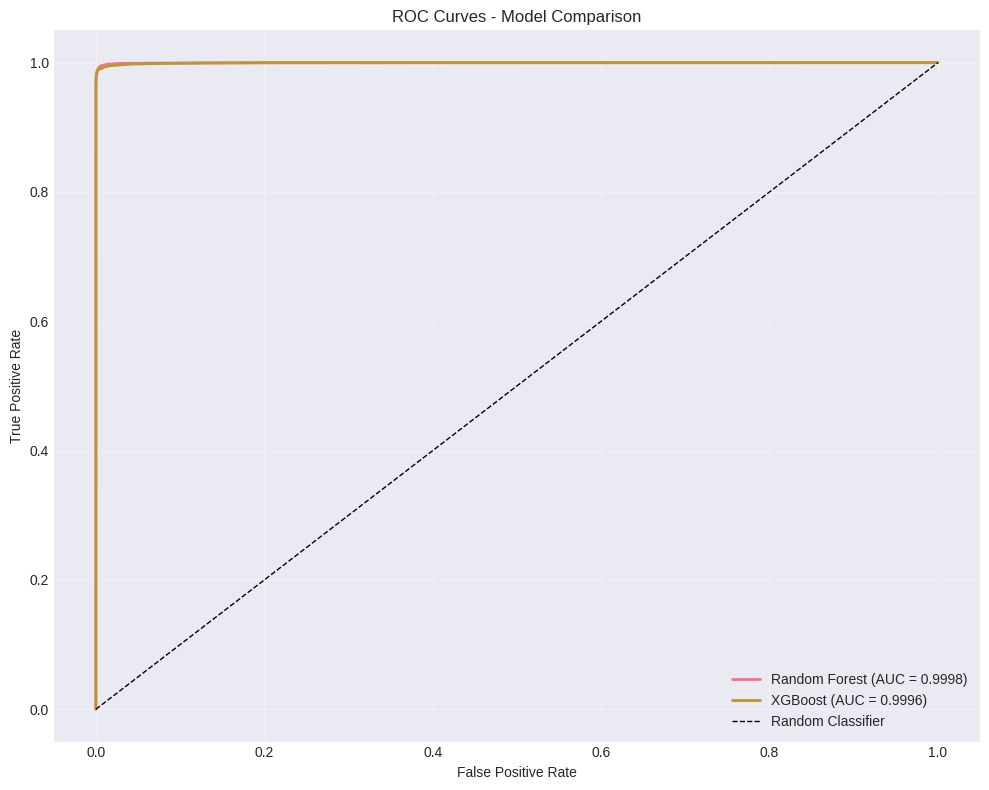

In [67]:
# ROC Curves
plt.figure(figsize=(10, 8))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.4f})', linewidth=2)

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()